# Bootstrap sampling

In [1]:
import xarray as xr
import numpy as np
import sys
import random
from scipy import stats
import glob
from resampling import _resample_iterations_idx
from definitions import * # imports all functions from definitions.py

xr.set_options(keep_attrs = True, display_style = 'html')  # Attributes of DataArrays will be kept through operations.

alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/PW_GW_analysis/'
dir_path = '/home/hochatmstud/bene/'

In [2]:
def g_kde(y, x):
    """Firstly, kernel density estimation of the probability density function of randomized anomalies.
    Secondly, evaluates the estimated pdf on a set of points.
    
    Args:
        y (np.array): datapoints to estimate from (randomized anomalies)
        x (np.array): datapoints to be evaluated (composite values)
    Returns:
        np.array: the estimated pdf on composite values
    """
    print(y)
    mask = np.isnan(y)
    kde = stats.gaussian_kde(y[~mask])
    return kde(x)

In [3]:
station = 'Leipzig'

In [4]:
# Parameters
station = "Sodankyla"


## Wind measurements

In [5]:
ds_wind = read_group('wind',station)

u = read_var(ds_wind,'u0')
v = read_var(ds_wind,'v0')

u_anomalie = anomalie('dayofyear',u)

v_anomalie = anomalie('dayofyear',v)

sea_u = sea(40,station,u)
sea_u_anomalie = sea(40,station,u_anomalie)

sea_v = sea(40,station,v)
sea_v_anomalie = sea(40,station,v_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
#var = sys.argv[1] # ta, ua ; input variable
time_scale = sys.argv[2] # 20 or 30 ; input timescale
its = 10000 # 10000 ; number of samples
#what = sys.argv[4] # anomalies ; what kind of anomalies
#DJF_bool = sys.argv[5] # DJF only (bool)
rechunk = True # allows rechunking in xr.apply_ufunc

if station == 'Leipzig':
    size = 7
elif station == 'Esrange':
    size = 11
elif station == 'Sodankyla':
    size = 4
elif station == 'Sodankyla_Kiruna':
    size = 11
elif station == 'CMOR':
    size = 9
elif station == 'RioGrande':
    size = 4
elif station == 'Davis':
    size = 7

line_width = 5

In [7]:
#u_anomalie
u_anomalie['name'] = 'statistical significance'

### for-loop via the lags

In [8]:
u_anomalie = u_anomalie.sel(alt=slice(80,100)).dropna('time')

In [9]:
sea_u_anomalie = sea_u_anomalie.sel(alt=slice(80,100)).dropna('days')

In [10]:
p = []

for lag in range(-40,41,1):
    #print(comp_name, size)
    # samples generation (loaded from external function)
    rnd_arr = _resample_iterations_idx(u_anomalie, 
                                    its, 'time', replace=True, chunk=False, dim_max = size) 
    #print(rnd_arr)
    print("".ljust(line_width)+'{} samples generated'.format(its))
    ## load of composite dataarray
    #comp_file = f'{root_path}composites_woSSW{w_clim}/{var}_{what}_comp_{comp_name}_{time_scale}days.nc'
    #ds_comp = xr.open_dataarray(comp_file)*factor
    #print("".ljust(line_width)+'{} opened'.format(comp_file))
    
    # statistical significance calculation (vectorized g_kde)
    da_kde = xr.apply_ufunc(g_kde, rnd_arr, sea_u_anomalie.sel(days=lag),\
                       input_core_dims=[['iteration'], []],\
                       vectorize=True, dask='parallelized',\
                       exclude_dims=set(("iteration",)),  \
                       output_core_dims=[[]], \
                       output_dtypes=[sea_u_anomalie['u0_mean'].dtype])
    print("".ljust(line_width)+'p-values calculated')
    # output the calculation                        
    #outfile_name = f'{dir_path}bootstrap_test_{station}_lag_{lag}.nc'
    da_kde['name'] = u_anomalie['name']
    #da_kde.to_netcdf(outfile_name)
    #print("".ljust(line_width)+'{} saved'.format(outfile_name))
    #del da_kde, rnd_arr, ds_comp
    #print()
    #da_kde.plot.scatter(y='alt', x='u0_mean')
    #da_kde.plot.scatter(y='alt', x='u0_std')
    p.append(da_kde) 

     10000 samples generated
[ 2.44215909 -0.44160354 -2.13214773 ... -5.10890909 -1.91386364
  3.71011364]
[ 1.43852273  0.48298295 -3.22320455 ... -5.52838636 -2.72522727
  3.00897727]
[ 0.18102273  0.17182449 -3.43256818 ... -5.36267045 -3.34625
  2.7725    ]
[-1.07534091 -1.27459596 -3.62939773 ... -5.45847727 -2.91647727
  2.25829545]
[-2.04681818 -2.99475694 -4.08585227 ... -5.56263636 -2.16818182
  2.04147727]
[-2.71954545 -4.16699495 -4.80942045 ... -5.36518182 -0.87181818
  1.76545455]
[-2.31181818 -5.30442235 -5.41163636 ... -4.98254545  0.72193182
  1.98977273]
[-2.00670455 -6.41789141 -5.69185227 ... -4.286375    1.90329545
  2.29477273]
[-2.37511364 -6.52117109 -5.96848864 ... -3.341375    2.99215909
  2.40897727]
[-2.69579545 -6.41359848 -7.24393182 ... -2.053625    3.98909091
  1.55295455]
[ 0.61505177 -6.94099432 -9.42635227 ...  0.08470455  8.47352557
 -2.65      ]
[ 2.44215909 -0.44160354 -2.13214773 ... -5.10890909 -1.91386364
  3.71011364]
[ 1.43852273  0.48298295 -

     10000 samples generated
[ 1.47674432 -1.99919508 -1.71596591 ... -3.73397727  6.41210227
  8.46785038]
[-0.56828788 -3.48007576 -2.22611364 ... -2.94306818  7.7307197
  7.80892045]
[-1.65821591 -4.63768939 -2.26139773 ... -2.50545455  8.15947917
  7.58151515]
[-2.09212879 -5.3804072  -1.46757955 ... -2.56556818  7.3110322
  6.60969697]
[-3.27790341 -5.83105114 -0.24214773 ... -2.46863636  5.84697917
  5.38104167]
[-4.22114962 -5.7634375   0.67972727 ... -1.65261364  4.08306818
  4.27999053]
[-5.3590303  -5.94719697  0.66196591 ... -0.93431818  3.36532197
  2.91110795]
[-5.94269318 -6.20598485  1.04363636 ...  0.44465909  1.38577652
  1.90249053]
[-5.83695455 -6.71932765  1.609125   ...  1.23375    -1.34375
  0.39525568]
[-5.57055871 -7.81479167  2.14897727 ...  2.88431818 -3.83253788
 -0.09120265]
[-5.42113636 -8.61675379 -0.47814773 ...  4.45375    -8.52167929
 -1.70087798]
[ 1.47674432 -1.99919508 -1.71596591 ... -3.73397727  6.41210227
  8.46785038]
[-0.56828788 -3.48007576 -2.

[ 7.4289678  -5.95090909 -4.39420455 ...  0.87488636  3.12257955
  1.83273864]
[ 9.76076705 -7.09659091 -2.96068182 ...  1.75727273  2.50552273
  2.30064773]
[12.25714962 -7.96409091 -0.96488636 ...  2.77965909  1.60385227
  2.83571591]
[14.2996875  -7.90420455  1.52738636 ...  3.24329545  0.56390909
  3.01594318]
[13.44163826 -7.76215909  2.43261364 ...  2.74272727 -0.61605682
  3.75330682]
[12.75392235 -7.79840909  6.70011364 ...  0.53897727 -2.68649747
  4.419875  ]
     p-values calculated
     10000 samples generated
[-0.12305682  4.49956439  1.95087121 ... -2.78727273 -1.65133838
 -2.02590909]
[-1.48431818  5.05337121  0.83867424 ... -2.55409091 -1.93280303
 -0.84693182]
[-1.79220455  5.05811553  0.44644886 ... -2.15022727 -2.54660354
 -0.09      ]
[-2.08025     4.98496212 -0.40527462 ... -1.41784091 -2.88277778
  0.47795455]
[-1.694       4.81338068 -2.72886364 ... -0.21238636 -3.16868687
  1.12545455]
[-1.52867045  4.33920455 -5.1070928  ...  1.34193182 -3.43487374
  1.78818182

     10000 samples generated
[-5.49897727 -0.80844823 -0.64580682 ...  2.62321591  5.44454545
  0.36484091]
[-5.91943182 -0.16237879 -0.02575    ...  4.85642045  5.66852273
  0.11490909]
[-6.38556818 -0.37231566  1.55701136 ...  6.23985227  5.04886364
  1.11842045]
[-5.71988636 -0.95902652  3.12530682 ...  8.20339773  3.83772727
  2.074625  ]
[-5.33818182 -2.0769899   4.90476136 ...  9.69734091  2.85329545
  2.69365909]
[-5.43079545 -2.67317424  6.67925    ... 10.56722727  2.12443182
  1.99436364]
[-5.77852273 -2.92181818  7.97172727 ... 11.17815909  1.05704545
  0.09379545]
[-6.34545455 -3.97113636  8.71934091 ... 11.10693182  0.01352273
 -0.96910227]
[-6.58068182 -4.41529798  8.52415909 ... 10.49544318 -0.38318182
 -0.45397727]
[-6.76045455 -4.86897222  8.34767045 ...  9.18885227 -0.51431818
  0.53960227]
[-1.92556818 -5.30349116  7.89310227 ...  8.33782955 -1.36227273
  3.05343994]
[-5.49897727 -0.80844823 -0.64580682 ...  2.62321591  5.44454545
  0.36484091]
[-5.91943182 -0.1623787

[ 1.45909091 -1.92392045 -1.86778409 ...  5.46784091  0.79460227
  5.16219318]
[ 1.41303409 -2.84882955 -2.33871591 ...  5.03931818  0.36140909
  5.42947727]
[ 0.90515909 -4.14856818 -4.0598608  ...  6.14136364  1.34940909
  2.92955682]
[ 1.77297727 -0.55576136 -8.35326136 ...  7.88568182  1.67536364
  5.88592045]
[ 1.86844318 -0.48015909 -6.68379545 ...  8.07511364  2.67831818
  5.16543182]
[ 2.79601136 -0.644125   -4.38503409 ...  8.53534091  3.47561364
  4.35618182]
[ 4.02588636 -1.06623864 -2.94385227 ...  9.23488636  3.67536364
  4.204125  ]
[ 4.27122727 -1.79879545 -1.99322727 ...  9.18238636  4.00529545
  3.55721591]
[ 3.98272727 -2.52920455 -1.37852273 ...  8.68579545  4.03414773
  3.83228409]
[ 3.40070455 -2.97453409 -1.20703409 ...  7.74113636  3.16395455
  4.01904545]
[ 2.4365     -2.45617045 -1.56503409 ...  6.5475      2.06044318
  4.37257955]
[ 1.45909091 -1.92392045 -1.86778409 ...  5.46784091  0.79460227
  5.16219318]
[ 1.41303409 -2.84882955 -2.33871591 ...  5.03931818

[1.97675189 5.78425505 3.20863636 ... 1.35386364 9.96172348 4.90942045]
[ 1.81897727  6.29598485  3.81784091 ...  3.21090909 10.01513258
  6.19136364]
[1.34214015 6.76515152 3.27534091 ... 3.78045455 9.13804924 6.87527273]
[0.32804924 6.12592172 2.06852273 ... 4.22965909 7.5533428  7.68814773]
[0.36318182 4.44371212 1.32136364 ... 3.05215909 5.59690341 8.51628409]
[3.17189394 3.10410354 0.31852273 ... 1.45011364 2.72675189 9.30381818]
[ 3.90612121  1.08857504  1.00079545 ... -0.11329545 -0.81321023
  3.74626136]
     p-values calculated
     10000 samples generated
[-2.69862689  8.44497727  4.29228598 ... -0.7        -8.72645833
  1.77528409]
[-1.6105303   8.23252273  6.35866477 ... -1.97806818 -8.73155303
  0.31411932]
[-0.04930871  7.63854545  6.31785038 ... -3.96613636 -8.30875947
 -0.49434659]
[ 1.34529356  6.86995455  5.23036932 ... -5.75363636 -7.34233902
 -1.79246212]
[ 1.79558712  5.50198864  3.12446023 ... -7.09738636 -5.8259375
 -3.15515152]
[ 2.20017045  4.44470455  1.712708

     p-values calculated
     10000 samples generated
[-5.23534091 -1.54738636  3.956375   ... -1.57443182  3.07238636
 -0.44657828]
[-4.14068182 -2.77670455  3.03981818 ... -1.26784091  2.74068182
 -2.17040404]
[-3.69613636 -3.60852273  3.01682955 ... -1.23261364  2.95056818
 -2.88063131]
[-3.12170455 -4.83965909  2.445      ... -1.26556818  2.40511364
 -3.82348485]
[-2.31988636 -5.40113636  0.93495455 ... -1.31318182  2.29136364
 -4.2394697 ]
[-1.77920455 -6.75545455  0.11610227 ... -2.04988636  2.22022727
 -3.87752525]
[-1.48795455 -7.82181818  0.53006818 ... -2.58863636  2.14886364
 -3.70885101]
[-1.39011364 -8.44636364  1.43354545 ... -3.38147727  1.43306818
 -3.46876263]
[-1.71465909 -9.02931818  2.42696591 ... -3.26534091  1.19227273
 -3.07568182]
[-1.9475     -9.63761364  2.68503409 ... -3.27681818  0.48363636
 -1.63545455]
[-1.53318182 -8.23577273  4.06673864 ... -2.86330682 -0.04511364
 -1.12370851]
[-5.23534091 -1.54738636  3.956375   ... -1.57443182  3.07238636
 -0.44657828

     10000 samples generated
[ 7.42942045  3.56593434  8.62659091 ... -0.04238636 -2.63401326
 -5.29431818]
[ 7.41515909  2.36141414  6.38068182 ...  1.13238636 -2.03581818
 -5.43045455]
[ 7.18542045  0.50545455  4.33863636 ...  2.98840909 -1.66314583
 -4.67897727]
[ 6.23530682 -0.215       2.62272727 ...  3.62681818 -0.43572348
 -4.37136364]
[ 4.75885227 -0.28992045  0.36284091 ...  4.43647727  0.36975379
 -3.61534091]
[ 3.07845455 -0.470125   -1.31068182 ...  5.57488636  1.02282386
 -3.03886364]
[ 1.94718182 -0.73064773 -2.07602273 ...  5.79943182  1.3133447
 -2.70363636]
[ 1.60911364 -1.03344318 -2.28522727 ...  5.38147727  0.92479545
 -2.41170455]
[ 1.31643182 -0.69097222 -1.99465909 ...  4.05204545 -0.7119072
 -1.78556818]
[ 1.41971591 -1.23001263 -1.31420455 ...  3.57375    -2.09039015
 -0.99727273]
[ 3.24347159 -1.90539141 -1.16800505 ...  3.11227273  1.75728409
 -2.47034091]
[ 7.42942045  3.56593434  8.62659091 ... -0.04238636 -2.63401326
 -5.29431818]
[ 7.41515909  2.36141414 

[-0.05295455 -3.07367045  6.6275     ... -0.16443182 -4.20655682
  6.49747159]
[ 1.61806818 -1.10635227  5.73159091 ...  1.13409091 -4.04234091
  6.04585227]
[ 3.69784091  0.31788636  4.67715909 ...  2.85068182 -2.19123864
  4.69037879]
[3.00088384 1.42892677 2.48340909 ... 4.09352633 2.52323864 4.82765152]
[-11.50272727  -5.22779545   2.01806818 ...  -0.92590909  -2.8465
   0.28867424]
[-10.66272727  -5.91901136   4.31647727 ...  -1.12579545  -3.47109091
   0.83099432]
[-9.65931818 -6.21517045  5.33090909 ... -2.40647727 -3.81025
  2.00224432]
[-8.15363636 -6.00234091  6.23875    ... -3.15170455 -3.82332955
  3.07533144]
[-6.48090909 -5.21092045  7.07568182 ... -3.69511364 -3.60679545
  4.71341856]
[-4.45284091 -4.6575      7.75704545 ... -3.06397727 -2.94296591
  6.16362689]
[-2.33261364 -4.16501136  7.78431818 ... -1.78022727 -3.63038636
  6.80520833]
[-0.05295455 -3.07367045  6.6275     ... -0.16443182 -4.20655682
  6.49747159]
[ 1.61806818 -1.10635227  5.73159091 ...  1.13409091 -

[ 2.86109848 -0.04738636  1.33944129 ... 12.04943182 -3.85375
 -0.26113636]
[ 0.17804293  0.44511364  0.66848864 ... 10.88886364 -5.39784091
 -0.30590909]
[-2.14941919 -0.31988636  0.24938636 ... 10.01318182 -7.10375
 -0.73170455]
[-4.0035101  -2.04079545 -0.31463636 ...  8.77534091 -8.81352273
 -0.19011364]
[ -5.40659091  -3.25886364  -0.39154924 ...   7.82261364 -10.05556818
  -0.12170455]
[ -6.54227273  -3.62568182  -0.09988826 ...   7.59681818 -11.13102273
   0.05193182]
[ -6.79671717  -4.02272727   0.40519318 ...   6.30579545 -11.65227273
   0.01409091]
[ -6.40362374  -4.34352273   1.01685417 ...   4.39875    -11.735
   0.22136364]
[ -6.15710859  -4.59238636   0.98369318 ...   3.2525     -11.68613636
   1.00875   ]
[ -5.97492424  -4.40352273   1.34530114 ...   2.75704545 -11.64602273
   1.69681818]
[ -6.43940909  -3.82114899   0.01723295 ...  -1.76316919 -12.31622475
   3.06386364]
     p-values calculated
     10000 samples generated
[ 1.02465909 -0.66170455 13.11507955 ... -5.13

[ 3.853125   -0.97960227 -4.96306818 ... -5.13920455  3.00623737
  8.59409091]
[ 3.94931818  0.36370455 -4.81113636 ... -5.12568182  4.11075758
  9.67568182]
[ 3.55012311  1.49813636 -4.56613636 ... -5.35488636  5.19430556
  9.66534091]
[ 5.13471591  6.61601136 -1.43186364 ... -5.06965909  6.13444444
  8.21852273]
     p-values calculated
     10000 samples generated
[-0.01465909  7.47161364 -3.74579545 ... -6.96579545 -3.52382955
  1.44707071]
[ 1.47340909  6.11456818 -3.32215909 ... -5.23079545 -3.97872727
  1.22829545]
[ 2.55170455  3.79561364 -2.56261364 ... -3.25659091 -3.89922727
  0.58737374]
[ 4.16556818  1.48377273 -2.02431818 ... -0.93829545 -3.11593182
  1.07816919]
[ 5.32011364 -0.49913636 -1.59715909 ...  1.15204545 -2.50776136
  1.76755051]
[ 6.18818182 -1.920625   -0.73602273 ...  2.14579545 -2.60568182
  2.17800505]
[ 6.67693182 -3.10275     0.35886364 ...  2.36       -2.81578409
  1.95501263]
[ 5.53022727 -3.97648864  1.97556818 ...  2.56556818 -3.21834091
  1.72136364

     10000 samples generated
[ -2.25818182   3.19073864  -6.59920455 ... -14.06837121  -6.19329545
   8.07625   ]
[ -2.44288636   5.83059091  -6.62363636 ... -11.75166667  -5.18068182
   6.21693182]
[-2.51726136  7.48802273 -6.58977273 ... -9.63341856 -3.95545455
  5.10863636]
[-2.54561364  8.45413636 -6.78238636 ... -8.25402462 -2.49011364
  3.76272727]
[-2.65527273  9.19819318 -7.07488636 ... -6.32221591 -1.01340909
  2.87034091]
[-3.24780682  9.51061364 -7.13068182 ... -4.50285985  0.59045455
  1.74090909]
[-4.02529545  9.39736364 -7.18602273 ... -3.03830492  1.89034091
  0.42784091]
[-4.94832955  8.39570455 -6.61409091 ... -0.82139205  2.53704545
 -0.65556818]
[-5.45006818  7.55526136 -4.80443182 ...  1.20328598  2.64795455
 -1.99897727]
[-5.49147727  5.748875   -3.72477273 ...  1.50626705  2.84204545
 -3.08875   ]
[-3.16646591  3.62014773 -3.44184659 ... -1.14937689  3.0535
 -6.30146307]
[ -2.25818182   3.19073864  -6.59920455 ... -14.06837121  -6.19329545
   8.07625   ]
[ -2.4428

[-6.14092803  0.07363636 -0.9886553  ... -0.74988636  2.23278409
  1.65238636]
[-7.46153409  1.22693182 -0.48357955 ... -0.23170455  1.37271591
  1.82840909]
[-7.85136364  1.78829545  0.51567235 ...  0.77125     1.34119318
  2.62181818]
[-8.14695644  1.95284091  1.73026515 ...  1.20136364  0.64847727
  3.85454545]
[-9.72701136 -2.46361364  2.31942235 ...  2.4        -0.02944318
  3.72738636]
[ 3.00815341 -3.48068182 -7.03589015 ...  1.16147727  2.35830682
 -0.80227273]
[ 0.87575758 -3.16136364 -6.69666667 ...  1.37590909  2.38469318
  0.45818182]
[-0.68681818 -3.20965909 -5.97785038 ...  0.59954545  2.37769318
  0.83784091]
[-1.96225379 -3.07954545 -4.65995265 ... -0.33340909  2.34631818
  1.31590909]
[-3.56997159 -2.25556818 -3.1371875  ... -0.96386364  2.90540909
  1.56488636]
[-4.95141098 -1.24511364 -2.05267992 ... -1.14988636  2.96039773
  1.82443182]
[-6.14092803  0.07363636 -0.9886553  ... -0.74988636  2.23278409
  1.65238636]
[-7.46153409  1.22693182 -0.48357955 ... -0.23170455

In [11]:
p_comp =  xr.concat(p, dim = 'days')
p_comp['days'] = range(-40, 40+1)
p_comp = p_comp.where(p_comp['u0_mean'] < 0.05, other = -0.05)

In [12]:
#p_comp

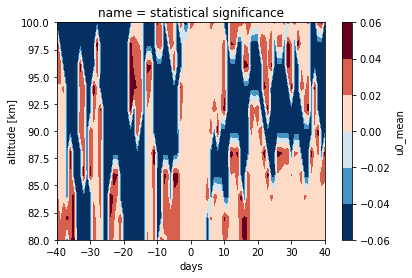

In [13]:
p_comp['u0_mean'].plot.contourf(x='days')